In [1]:
from opteval import benchmark_func as bf
import matplotlib.pyplot as plt
import numpy as np
import GPy
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import norm, beta
from scipy.optimize import minimize, differential_evolution
import seaborn as sns
print(bf.__all__)
from itertools import product
import warnings
warnings.filterwarnings("ignore")

 /opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning:numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
 /opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning:numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


['Ackley', 'Sphere', 'Rosenbrock', 'Beale', 'GoldsteinPrice', 'Booth', 'BukinN6', 'Matyas', 'LeviN13', 'ThreeHumpCamel', 'Easom', 'Eggholder', 'McCormick', 'SchafferN2', 'SchafferN4', 'StyblinskiTang', 'DeJongsF1', 'DeJongsF2', 'DeJongsF3', 'DeJongsF4', 'DeJongsF5', 'Ellipsoid', 'KTablet', 'FiveWellPotential', 'WeightedSphere', 'HyperEllipsodic', 'SumOfDifferentPower', 'Griewank', 'Michalewicz', 'Perm', 'Rastrigin', 'Schwefel', 'SixHumpCamel', 'Shuberts', 'XinSheYang', 'Zakharov']


В данном ноутбуке сравним биномиальную и гауссовскую оптимизации в случае некоторых двумерных функций:

In [2]:
default_funct_dict =  {'Ackley': bf.Ackley(2),
                       'Rosenbrock': bf.Rosenbrock(2),
                       'Beale': bf.Beale(),
                       'GoldsteinPrice': bf.GoldsteinPrice(),
                       'Booth': bf.Booth(),
                       'BukinN6': bf.BukinN6(),
                       'Matyas': bf.Matyas(),
                       'ThreeHumpCamel': bf.ThreeHumpCamel(),
                       'Eggholder': bf.Eggholder(),
                       'Zakharov': bf.Zakharov(2),
                       'LeviN13': bf.LeviN13(),
                       'StyblinskiTang': bf.StyblinskiTang(2),
                       'Michalewicz': bf.Michalewicz(2),                                 
                       'Rastrigin': bf.Rastrigin(2)
                        }
RANK = 2
            
def get_min_max(f_name):
    f = default_funct_dict[f_name]
    L = [f.get_search_range()[0][0]]
    mins = [differential_evolution(lambda t: f.get_func_val(np.array(t).reshape(RANK)), [(-L[0], L[0])] * RANK).fun for _ in range(10)]
    maxs = [-differential_evolution(lambda t: -f.get_func_val(np.array(t).reshape(RANK)), [(-L[0], L[0])] * RANK).fun for _ in range(10)]
    return np.min(mins) * 0.9, np.max(maxs) * 1.1

min_max_dict = {key:get_min_max(key) for key in default_funct_dict.keys()}



In [3]:
def compute(f_name, x):
    f = default_funct_dict[f_name]
    min_v, max_v = min_max_dict[f_name]
    x = np.array(x).reshape(-1, RANK)
    ans = np.array([(f.get_func_val(q.reshape(RANK, 1)) * 0.9 - min_v) / (max_v - min_v + 1e-8) for q in x]).reshape(x.shape[0], 1)
    return ans

def generate_value(f_name, x, sigma=0.01):
    f = lambda t: compute(f_name, t.reshape(-1, RANK))
    return np.random.binomial(N, f(x)).reshape(x.shape[0], 1)

def plot(f_name):
    x = np.arange(-L[0],L[0],0.01).reshape(-1,1)
    arr = compute(f_name, x)
    plt.plot(x, arr)
    plt.show()

def get_progress(Y):
    return np.minimum.accumulate(Y/N)

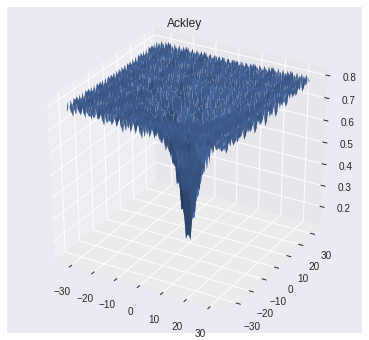

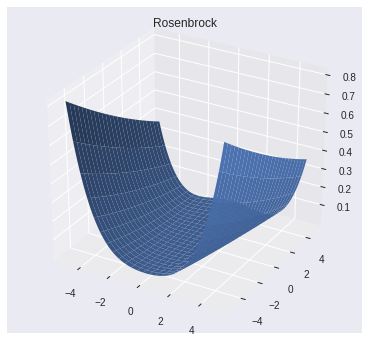

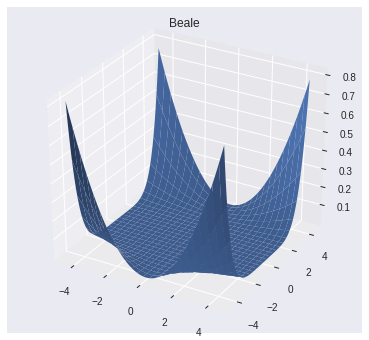

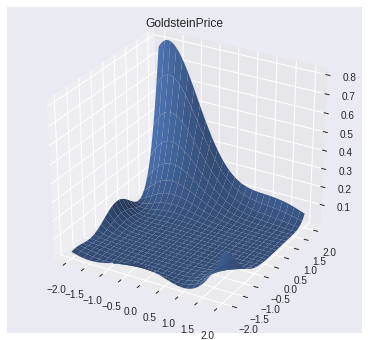

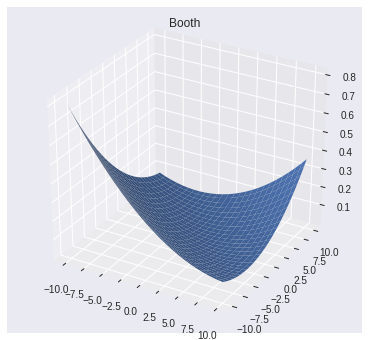

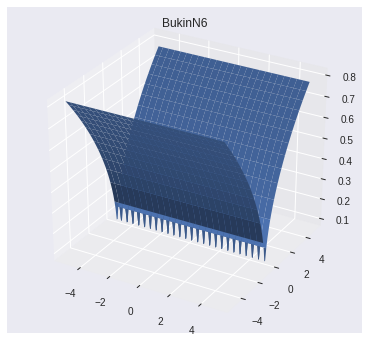

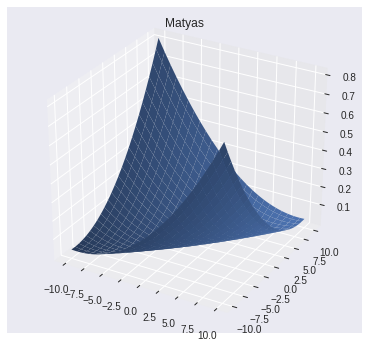

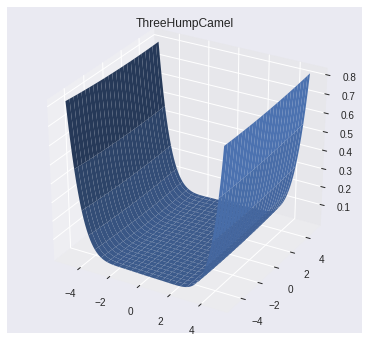

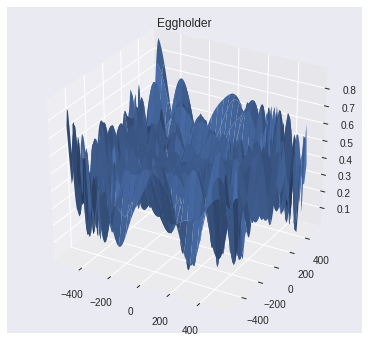

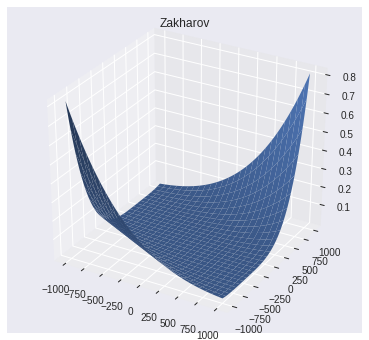

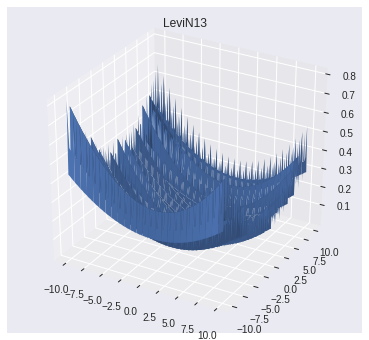

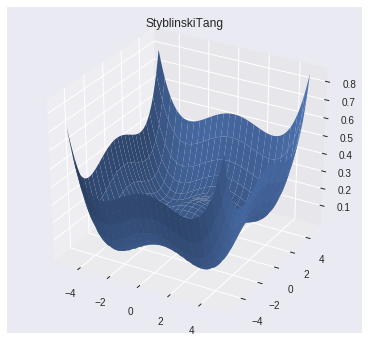

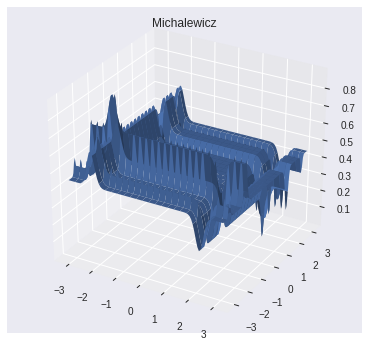

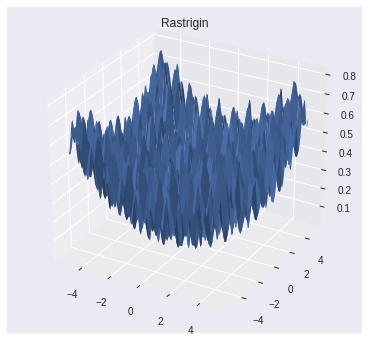

In [4]:
def plot(f_name):
    f = default_funct_dict[f_name]
    L = f.get_search_range()[0][0]
    xs = np.linspace(-L, L, 100)
    ys = np.linspace(-L, L, 100)
    xs, ys = np.meshgrid(xs, ys)
    values = compute(f_name, np.dstack([xs, ys]).reshape(10000, 2)).reshape(100, 100)
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)
    plt.title(f_name)
    plt.show()
    
for key in default_funct_dict.keys(): plot(key)

In [5]:
def EI(x, model, opt_value):
    mean_value, variance_value = model.predict(x.reshape(1,RANK))
    std_value = np.sqrt(variance_value)
    improvement = (opt_value - mean_value).ravel()
    std_value = std_value.ravel()
    EI = improvement * norm.cdf(improvement / std_value) + std_value * norm.pdf(improvement / std_value)    
    return EI

def get_new_point(X, Y, model, opt_value):

    starting_points = np.random.uniform(-L, L, [10, RANK])
    
    max_EI = np.inf
    for starting_point in starting_points:
        current_EI = minimize(lambda t: -EI(t, model, opt_value), starting_point, \
                            method='L-BFGS-B', bounds=np.array([-L,L]*RANK).reshape(RANK,2))
        if current_EI.fun < max_EI:
            max_EI = current_EI.fun
            new_point = current_EI.x.reshape(1,RANK)
    new_value = generate_value(f_name, new_point)
    return new_point, new_value

def EI_approx(x, model, opt_value):
    mean_value, variance_value = model._raw_predict(x.reshape(1,RANK))
    std_value = np.sqrt(variance_value)
    EI = []
    binomial = GPy.likelihoods.Binomial()
    n_sample = N
    
    for mean, std in zip(mean_value, std_value):
        samples = np.random.normal(mean, std, n_sample)
        samples = samples[binomial.gp_link.transf(samples)<opt_value]
        if len(samples) > 0:
            EI.append(np.mean(opt_value - binomial.gp_link.transf(samples)))
        else:
            EI.append(0)   
    return np.array(EI)

def get_new_point_approx(X, Y, model, opt_value):

    starting_points = np.random.uniform(-L, L, [10, RANK])
    
    max_EI = np.inf
    for starting_point in starting_points:
        current_EI = minimize(lambda t: -EI_approx(t, model, opt_value), starting_point, \
                            method='L-BFGS-B', bounds=np.array([-L,L]*RANK).reshape(RANK,2))
        if current_EI.fun < max_EI:
            max_EI = current_EI.fun
            new_point = current_EI.x.reshape(1,RANK)
    new_value = generate_value(f_name, new_point)
    

    return new_point, new_value

In [ ]:
def experiment(N):
    variance = 1
    
    ###
    
    X = np.ones([1,RANK]) * L[0] * 0.9
    Y = generate_value(f_name, X)
    opt_value = np.min(Y)
    ker = GPy.kern.RBF(RANK, variance=variance)
    m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)
    
    for _ in range(60):
        m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)
        x,y = get_new_point(X, Y, m, opt_value)
        X = np.append(X, x, axis=0)
        Y = np.append(Y, y, axis=0)
        opt_value = np.min(Y)
    
    q1 = get_progress(Y)

    ###
    
    X = np.ones([1,RANK]) * L[0] * 0.9
    Y = generate_value(f_name, X)
    trials = np.ones([len(X), 1], dtype='int') * N
    opt_value = np.min(Y)
    kernel = GPy.kern.RBF(RANK, variance=variance)
    binomial = GPy.likelihoods.Binomial()
    m = GPy.core.GP(X, Y, kernel=kernel, 
                                  Y_metadata={'trials': trials},
                                  inference_method=GPy.inference.latent_function_inference.Laplace(),
                                  likelihood=binomial)
    
    for _ in range(60):
        #Y = generate_value(f_name, X)
        trials = np.ones([len(X), 1], dtype='int') * N
        binomial = GPy.likelihoods.Binomial()
        m = GPy.core.GP(X, Y, kernel=kernel, 
                                  Y_metadata={'trials': trials},
                                  inference_method=GPy.inference.latent_function_inference.Laplace(),
                                  likelihood=binomial)
        x,y = get_new_point_approx(X, Y, m, opt_value)
        X = np.append(X, x, axis=0)
        Y = np.append(Y, y, axis=0)
        opt_value = np.min(Y)
        
    q2 = get_progress(Y)
    
    return q1, q2

In [ ]:
for f_name in default_funct_dict.keys():
    print(f_name)
    f = default_funct_dict[f_name]
    L = np.array([f.get_search_range()[0][0]])
    for N in [50]:
        Q1 = []
        Q2 = []
        for _ in trange(40):
            q1, q2 = experiment(N)
            Q1.append(q1)
            Q2.append(q2)
        fig = plt.figure()
        plt.ylabel('minimal true value')
        plt.title(f_name + ' N = '+str(N))
        sns.tsplot(Q1, color='b', ci=90)
        sns.tsplot(Q2, color='y', ci=90)
        fig.savefig('./images/'+f_name+' N50')
        plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

Ackley


  8%|▊         | 3/40 [02:44<33:48, 54.82s/it]

#### Графики сохранятся в папку ./images/